一次元畳み込みニューラルネットワークの実装

In [1]:
import time

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from scipy import linalg

## まず適当なテストデータを作る
1dCNNは多くの場合で時系列解析に用いられます。そのため、テストデータは簡単な異常検知モデルにしてみましょう。

※本来、時系列の異常検知システムは逐次的に見ることが多いので、本当はこんな風にバッチごとに見るようなことは少ないです。

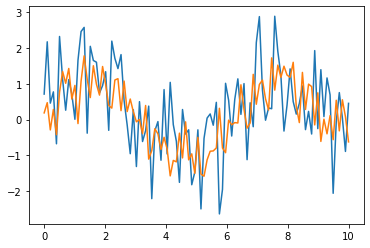

In [2]:
data_length = 100
n_sample = 100000
anomaly_noise = np.random.randn(data_length)    #異常値は分散が大きい
nomaly_noise  = np.random.randn(data_length)/2  #正常値は分散が小さい

#時系列とラベルを生成
t = np.linspace(0,10,data_length)
x_anomaly = np.array([np.sin(t) + anomaly_noise for i in range(n_sample//2)])
x_nomaly  = np.array([np.sin(t) + nomaly_noise  for i in range(n_sample//2)])
X = np.concatenate([x_anomaly,x_nomaly])
y = np.concatenate([np.ones(n_sample//2),np.zeros(n_sample//2)])

#シャッフル
rand_idx = np.arange(n_sample)
np.random.shuffle(rand_idx)
X = X[rand_idx,:]
y = y[rand_idx]

#描画
plt.plot(t,x_anomaly[0,:])
plt.plot(t,x_nomaly[0,:])
plt.show()

ここでは二値分類となっていますが、OneHotEncodingすれば、問題なく実行されるはずなので、二値ですがOneHotEncodingしましょう。

もちろん二値分類用に別に出力層を作っても問題ありません。余力があればぜひやってみてください。

## 訓練データとテストデータに分ける

In [3]:
X_train,X_test,y_train,y_test = train_test_split(X,y)

## 実装に向けて必要そうなクラスや関数リストをまとめておく

**最低限必要なLayer Class**
- 畳み込み層(Conv1d)
- 平滑化層(Flatten)
- 全結合出力層(Affin)
 - 回帰
 - 二値分類
 - 多値分類
- Pooling層

あればうれしい
- Global Average Pooling層
- Atrous層(Dilated層)

### Optimizerのクラス群
- SGD
- Adagrad

発展的なOptimizer
- Adam
- Eve
- 最近提案されたやつ(Adaboundsとか？)

## 実装していきましょう

関数名などは好きに設定してください。問題１の前に問題２に取り組んで、入力と出力の形の関係を考えましょう

### 【問題2】1次元畳み込み後の出力サイズの計算

$$
N_{out} = \frac{N_{in}+2P-F}{S}+1
$$

$N_{out}$ : 出力のサイズ（特徴量の数）


$N_{in}$ : 入力のサイズ（特徴量の数）


$P$ : ある方向へのパディングの数


$F$ : フィルタのサイズ


$S$ : ストライドのサイズ



In [4]:
def output_size(n_in, filter_size, pad=0, stride=1):
    n_out = (n_in + 2*pad - filter_size)// stride + 1
    return n_out

### 【問題１】チャンネル数の1に限定した一次元畳み込み層のクラスの作成

一次元畳み込み層のクラスを作成しましょう。DNNの時と同じような設計になるように、見比べながらやるといいです。

In [5]:
class Conv1d:
    """
    1D Convolution結合
    
    Parameters
    ----------
    filter_size : int
      フィルタのサイズ
    
    Attributes
    ----------
    A_ : 次の形のndarray, shape (batch_size, n_nodes_self)
      順伝播の出力
    dZ_ : 次の形のndarray, shape (batch_size, n_nodes_prev)
      逆伝播入力に対するdZ勾配
    dw_ : 次の形のndarray, shape (n_nodes_prev, n_nodes_self)
      逆伝播入力に対するdw勾配
    db_ : 次の形のndarray, shape (n_nodes_self, )
      逆伝播入力に対するdb勾配
    """
    def __init__(self):
        self.A_ = None
        self.dZ_ = None
        self.dw_ = None
        self.db_ = None
        
    def forward(self, Z, w, b):
        """
        順伝播
        
        Parameters
        ----------
        Z : 次の形のndarray, shape (batch_size, n_nodes_prev)
          ある層に順伝播された特徴量データ
        w : 次の形のndarray, shape (filter_size, )
          ある層の重み
        b : int
          ある層のバイアス
        """
        n_out = output_size(Z.shape[0], w.shape[0])
        
        id_Z = np.arange(n_out)[:,None]  #出力層分のindexを生成
        id_w = np.arange(w.shape[0])  #フィルタ数分のindexを生成

        id_array = id_Z + id_w  #ブロードキャストで計算用index arrayを生成; shape (n_out, w.shape)
        
        self.A_ = np.sum(Z[id_array] * w, axis=1) + b
        
        return self.A_
    
    def backward(self, Z, w, dA):
        """
        逆伝播
        
        Parameters
        ----------
        Z : 次の形のndarray, shape (batch_size, n_nodes_prev)
          ある層に順伝播された特徴量データ
        w : 次の形のndarray, shape (n_nodes_prev, n_nodes_self)
          ある層の重み
        dA : 次の形のndarray, shape (batch_size, n_nodes_self)
          ある層に逆伝播されたAに関するLoss勾配
        """
        n_out = output_size(Z.shape[0], w.shape[0])
        
        id_dA = np.arange(dA.shape[0])  #dA分のindexを生成
        id_Z = np.arange(Z.shape[0])[:,None]  #出力層分のindexを生成
        id_w = np.arange(w.shape[0])[:,None]  #フィルタ数分のindexを生成
        
        # dZ計算
        id_array_dZ = id_Z - id_dA  #ブロードキャスト用index
        mask = np.where((id_array_dZ < 0) | (id_array_dZ > n_out))
        id_array_dZ[mask] = 0
        w_mask = w[id_array_dZ]
        w_mask[mask] = 0
        self.dZ_ = np.sum(w_mask * dA, axis = 1)
        
        # dw計算
        id_array_dw = id_dA + id_w  #ブロードキャストで計算用index arrayを生成; shape (dA.shape, w.shape)
        self.dw_ = np.sum(Z[id_array_dw] * dA, axis=1)
        
        # db計算
        self.db_ = np.sum(dA, axis=0)
        
        return self.dZ_, self.dw_, self.db_

### 【問題3】小さな配列での1次元畳み込み層の実験

フォワードプロパゲーションでは入力とパラメータが以下のようになっているとき

In [6]:
x = np.array([1,2,3,4])
w = np.array([3, 5, 7])
b = np.array([1])

出力はこうなっているはずです
```python
a = np.array([35, 50])
```

バックプロパゲーションで誤差が以下のようなとき

In [7]:
delta_a = np.array([10, 20])

```python
delta_b = np.array([30])
delta_w = np.array([50, 80, 110])
delta_x = np.array([30, 110, 170, 140])
```
と、このようになります。

In [8]:
test = Conv1d()
test_A = test.forward(x, w, b)
test_dZ, test_dw, test_db = test.backward(x, w, delta_a)

print(test_A, test_db, test_dw, test_dZ)

[35 50] 30 [ 50  80 110] [ 30 110 170 140]


### 【問題4】チャンネル数を限定しない1次元畳み込み層クラスの作成

てプリッツ行列を使用した実装

[テプリッツ行列 - Wikipedia](https://ja.wikipedia.org/wiki/%E3%83%86%E3%83%97%E3%83%AA%E3%83%83%E3%83%84%E8%A1%8C%E5%88%97#:~:text=%E3%83%86%E3%83%97%E3%83%AA%E3%83%83%E3%83%84%E8%A1%8C%E5%88%97%EF%BC%88%E3%83%86%E3%83%97%E3%83%AA%E3%83%83%E3%83%84%E3%81%8E%E3%82%87%E3%81%86%E3%82%8C,%E3%81%AF%E6%95%B0%E5%AD%A6%E8%80%85%20Otto%20Toeplitz%E3%80%82)

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/e08105e2955d010a112ad34a350f24feb4c5ddcf)

In [9]:
class Conv1d:
    """
    1D Convolution
    
    Parameters
    ----------
    filter_size : int
      フィルタのサイズ
    
    Attributes
    ----------
    A_ : 次の形のndarray, shape (N, F, L)
      畳み込み出力
    dZ_ : 次の形のndarray, shape (N, C, Lo)
      逆伝播入力に対するdZ勾配
    dw_ : 次の形のndarray, shape (F, C, Lf)
      逆伝播入力に対するdw勾配
    db_ : 次の形のndarray, shape (F)
      逆伝播入力に対するdb勾配
    """
    def __init__(self, pad, stride):
        self.pad = pad
        self.stride = stride
        self.A_ = None
        self.dZ_ = None
        self.dw_ = None
        self.db_ = None
        
    def forward(self, Z, w, b):
        """
        順伝播
        
        Parameters
        ----------
        Z : 次の形のndarray, shape (N, C, L)
          ある層に順伝播された特徴量データ
        w : 次の形のndarray, shape (F, C, Lf)
          ある層の重み
        b : 次の形のndarray, shape (F)
          ある層のバイアス
        """
        L = Z.shape[-1]
        Lf = w.shape[-1]
        Lo = self._output_size(L, Lf) 
        
        self.A_ = self._convolve(Z, w) + b.reshape(1, len(b), 1)  # A(N,F,Lo)
        
        return self.A_
    
    
    def backward(self, Z, w, dA):
        """
        逆伝播
        
        Parameters
        ----------
        Z : 次の形のndarray, shape (N, C, L)
          ある層に順伝播された特徴量データ
        w : 次の形のndarray, shape (F, C, Lf)
          ある層の重み
        dA : 次の形のndarray, shape (N, F, Lo)
          ある層に逆伝播されたAに関するLoss勾配
        """        
        
        # dZ計算
        # チャンネル毎に演算を行うため、行列を転置（NとCを残す）
        w_ = np.transpose(w, (1,0,2))  # w(F,C,Lf) → w(C,F,Lf)
        w_ = np.flip(w_)  # 上下左右に反転
        # dAをpadding処理
        pad = w.shape[-1] - 1
        dA_ = np.pad(dA, [(0,0), (0,0), (pad, pad)])  # L次元のみpadding
        self.dZ_ = self._convolve(dA_, w_)  # dZ(N,C,L)
        
        
        # dw計算            
        # フィルタ毎に演算を行うため、行列を転置（FとCを残す）
        Z_ = np.transpose(Z, (1,0,2))  # Z(N,C,L) → Z(C,N,L)
        dA_ = np.transpose(dA, (1,0,2))  # dA(N,F,Lo) → dA(F,N,Lo)
        self.dw_ = np.transpose(self._convolve(Z_, dA_), (1,0,2))  # dw(C,F,Lf) → dw(F,C,Lf)

        
        # db計算 
        # F以外の次元の和をとる
        self.db_ = np.sum(dA, axis=(0,2))  # db(F)
        
        return self.dZ_, self.dw_, self.db_
    
    
    def _output_size(self, L, Lf):
        
        if self.pad == 'SAME':
            Lo = np.ceil(float(L) / float(self.stride))
        
        if self.pad == 'VALID':
            Lo = np.ceil(float(L - Lf + 1) / float(self.stride))

        return int(Lo)
    
    
    def _convolve(self, X, k):
        """
        巡回演算
        
        Parameters
        ----------
        X : 次の形のndarray, shape (N, C, L)
          巡回される行列
        k : 次の形のndarray, shape (F, C, Lf)
          巡回する行列
        """
        L = X.shape[-1]
        Lf = k.shape[-1]
        Lo = self._output_size(L, Lf) 

        # テプリッツ用wを生成
        pad = int(L - Lf)  # kの長さをXに合わせる
        k_pad = np.pad(k, [(0,0), (0,0), (0, pad)])  # k(F,C,Lf) → k(F,C,L)

        # 次元削減
        X_flat = X.reshape(len(X), -1)  # X(N,C,L) → X(N,CL)
        k_flat = k_pad.flatten()  # k(F,C,L) → k(FCL)

        first_col = np.r_[k_flat[0], np.zeros(Lo - 1)]  # テプリッツの１列目
        first_row = k_flat  # テプリッツの１行目  

        # テプリッツ行列を生成
        toep = linalg.toeplitz(first_col, first_row) # toep(Lo,FLC)

        # フィルタ毎に行列をブロック化し、縦に再結合
        toep_reorder = np.vstack(np.split(toep, len(k), axis=1))  #toep(FLo,LC)

        # 行列演算
        output = toep_reorder@X_flat.T  # out(FLo,N)

        return output.T.reshape(len(X), len(k), Lo)  # out(N,F,Lo)

問題３と同じく出力を確認しましょう。

フォワードプロパゲーションでは入力とパラメータが以下のようになっているとき

In [10]:
x = np.array([[1, 2, 3, 4], [2, 3, 4, 5]])[None,:,:] # shape(1, 2, 4)で、（次元数、入力チャンネル数、特徴量数）である。
w = np.ones((3, 2, 3)) # 例の簡略化のため全て1とする。(出力チャンネル数、入力チャンネル数、フィルタサイズ)である。
b = np.array([1, 2, 3]) # （出力チャンネル数）

```python
a = np.array([[16, 22], [17, 23], [18, 24]])
```

となっていれば正解です。

In [11]:
test = Conv1d(pad='VALID', stride=1)
dA = test.forward(x, w, b)
dz, dw, db = test.backward(x, w, dA)
dA

array([[[16., 22.],
        [17., 23.],
        [18., 24.]]])

### 【問題8】学習と推定

これまでと同じように、活性化関数やOptimizerのクラス（関数）を組み合わせて学習・推定させましょう。
チャンネル数が１よりも大きいときはうまく実行できません。なので、**平滑化**を行えるクラス（関数）を作りましょう。
発展的にGlobal Average Pollingを実装しても問題ありません。

In [12]:
class Flatten:
    def __init__(self):
        self.shape = None
        
    def forward(self, X):
        self.shape = X.shape
        return X.reshape(self.shape[0], np.prod(self.shape[1:]))  # X(N,C,L) → X(N,CL)
    
    def backward(self, dX):
        return dX.reshape(self.shape)

DNNの時と同じようにモデル全体を作っていきましょう。
まずは上に用意したデータなどで試して見てください。

In [13]:
class SGD:
    """
    確率的勾配降下法
    """
    def __init__(self):
        pass
        
    def update_dw(self, layer, grad):
        """
        ある層の重み勾配を渡す
        
        Parameters
        ----------
        layer: object instance
          ある層のインスタンス
        grad : 次の形のndarray, shape (n_nodes_prev, n_nodes_self)
          重みの勾配
        """
        return grad / layer.input.shape[0]
    
    def update_db(self, layer, grad):
        """
        ある層のバイアス勾配を渡す
        
        Parameters
        ----------
        layer: object instance
          ある層のインスタンス
        grad : 次の形のndarray, shape (n_nodes_self, )
          バイアスの勾配
        """
        return grad / layer.input.shape[0]
        

class AdaGrad:
    """
    AdaGradによる確率的勾配降下法
    
    Parameters
    ----------
    Hw : 次の形のndarray, shape (n_nodes_prev, n_nodes_self)
      ある層のイテレーション毎の重み勾配の二乗和
    Hb : 次の形のndarray, shape (n_nodes_self, )
      ある層のイテレーション毎のバイアス勾配の二乗和
    """
    def __init__(self):
        self.Hw = 1e-8
        self.Hb = 1e-8
        
    def update_dw(self, layer, grad):
        """
        ある層の重み勾配を渡す
        
        Parameters
        ----------
        layer: object instance
          ある層のインスタンス
        grad : 次の形のndarray, shape (n_nodes_prev, n_nodes_self)
          重みの勾配
        """
        self.Hw += (grad/layer.input.shape[0])**2
        grad *= (1/np.sqrt(self.Hw)) / layer.input.shape[0]
        
        return grad
    
    def update_db(self, layer, grad):
        """
        ある層のバイアス勾配を渡す
        
        Parameters
        ----------
        layer: object instance
          ある層のインスタンス
        grad : 次の形のndarray, shape (n_nodes_self, )
          バイアスの勾配
        """
        self.Hb += (grad/layer.input.shape[0])**2
        grad *= (1/np.sqrt(self.Hb)) / layer.input.shape[0]
        
        return grad
        
        
class Conv1d:
    """
    1D Convolution
    
    Parameters
    ----------
    pad : str
      VALID または SAME
    stride : int
      ストライド
    
    Attributes
    ----------
    A_ : 次の形のndarray, shape (N, F, L)
      畳み込み出力
    dZ_ : 次の形のndarray, shape (N, C, Lo)
      逆伝播入力に対するdZ勾配
    dw_ : 次の形のndarray, shape (F, C, Lf)
      逆伝播入力に対するdw勾配
    db_ : 次の形のndarray, shape (F)
      逆伝播入力に対するdb勾配
    """
    def __init__(self, pad='SAME', stride=1):
        self.pad = pad
        self.stride = stride
        self.A_ = None
        self.dZ_ = None
        self.dw_ = None
        self.db_ = None
        
    def forward(self, Z, w, b):
        """
        順伝播
        
        Parameters
        ----------
        Z : 次の形のndarray, shape (N, C, L)
          ある層に順伝播された特徴量データ
        w : 次の形のndarray, shape (F, C, Lf)
          ある層の重み
        b : 次の形のndarray, shape (F)
          ある層のバイアス
        """
        # 各種shapeやパラメータを定義
        L = Z.shape[-1]
        Lf = w.shape[-1]
        S = self.stride
        
        # パディング処理
        if self.pad == 'SAME':
            if L % S == 0:
                P = int((Lf - S) / 2)
            else:
                P = int((Lf - L%S) / 2)
            Z = self._padding(Z, P)
        elif self.pad == 'VALID':
            P = 0
        self.P = P
        
        self.A_ = self._convolve(Z, w, P, S) + b.reshape(1, len(b), 1)  # A(N,F,Lo)
        
        return self.A_
    
    def backward(self, Z, w, dA):
        """
        逆伝播
        
        Parameters
        ----------
        Z : 次の形のndarray, shape (N, C, L)
          ある層に順伝播された特徴量データ
        w : 次の形のndarray, shape (F, C, Lf)
          ある層の重み
        dA : 次の形のndarray, shape (N, F, Lo)
          ある層に逆伝播されたAに関するLoss勾配
        """        
        S = self.stride
        
        # dZ計算
        # チャンネル毎に演算を行うため、行列を転置（NとCを残す）
        w_ = np.transpose(w, (1,0,2))  # w(F,C,Lf) → w(C,F,Lf)
        w_ = np.flip(w_)  # 上下左右に反転
        # dAをdilate処理
        N, F, Lo = dA.shape
        dA_dil = np.zeros((N, F, S*Lo-S+1))  # Dilation matrixの準備
        dA_dil[...,::S] = dA
        # dA_dilをpadding処理
        pad = w.shape[-1] - 1
        dA_pad = np.pad(dA_dil, [(0,0), (0,0), (pad, pad)])  # L次元のみpadding
        # 巡回演算
        dZ_ = self._convolve(dA_pad, w_, 0, 1)  # dZ(N,C,L)
        # Padding除去
        if self.P == 0:
            self.dZ_ = dZ_
        else:
            self.dZ_ = self._padding_rm(dZ_, self.P)
        
        # dw計算            
        # フィルタ毎に演算を行うため、行列を転置（FとCを残す）
        Z_ = np.transpose(Z, (1,0,2))  # Z(N,C,L) → Z(C,N,L)
        dA_ = np.transpose(dA_dil, (1,0,2))  # dA(N,F,Lo) → dA(F,N,Lo)
        self.dw_ = np.transpose(self._convolve(Z_, dA_, self.P, 1), (1,0,2))  # dw(C,F,Lf) → dw(F,C,Lf)
        
        # db計算 
        # F以外の次元の和をとる
        self.db_ = np.sum(dA, axis=(0,2))  # db(F)
        
        return self.dZ_, self.dw_, self.db_
    
    def _output_size(self, L, Lf, P, S):
        Lo = (L + 2*P - Lf) / S + 1   
        return int(Lo)
    
    def _padding(self, X, n):
        # 順伝播用
        return np.pad(X, [(0,0), (0,0), (n,n)])

    def _padding_rm(self, X, n):
        # 逆伝播用
        return X[..., n:-n]
    
    def _convolve(self, X, k, P, S):
        """
        巡回演算
        
        Parameters
        ----------
        X : 次の形のndarray, shape (N, C, L)
          巡回される行列
        k : 次の形のndarray, shape (F, C, Lf)
          巡回する行列
        P : int
          パディング数
        S : int
          ストライド数
        """
        L = X.shape[-1]
        Lf = k.shape[-1]
        Lo = self._output_size(L, Lf, P, S) 

        # テプリッツ用wを生成
        pad = int(L - Lf)  # kの長さをXに合わせる
        k_pad = np.pad(k, [(0,0), (0,0), (0, pad)])  # k(F,C,Lf) → k(F,C,L)
        # 次元削減
        X_flat = X.reshape(len(X), -1)  # X(N,C,L) → X(N,CL)
        k_flat = k_pad.flatten()  # k(F,C,L) → k(FCL)
        # テプリッツ行列を生成
        first_col = np.r_[k_flat[0], np.zeros(S * (Lo-1))]  # テプリッツの１列目
        first_row = k_flat  # テプリッツの１行目  
        toep = linalg.toeplitz(first_col, first_row) # toep(Lo,FLC)
        # ストライドに対応した行のみを取得
        toep = toep[::S] 
        # フィルタ毎に行列をブロック化し、縦に再結合
        toep_reorder = np.vstack(np.split(toep, len(k), axis=1))  #toep(FLo,LC)
        # 行列演算
        output = toep_reorder@X_flat.T  # out(FLo,N)

        return output.T.reshape(len(X), len(k), Lo)  # out(N,F,Lo)
    

class Linear:
    """
    線形結合
    
    Parameters
    ----------
    A_ : 次の形のndarray, shape (batch_size, n_nodes_self)
      順伝播の出力
    dZ_ : 次の形のndarray, shape (batch_size, n_nodes_prev)
      逆伝播入力に対するdZ勾配
    dw_ : 次の形のndarray, shape (n_nodes_prev, n_nodes_self)
      逆伝播入力に対するdw勾配
    db_ : 次の形のndarray, shape (n_nodes_self, )
      逆伝播入力に対するdb勾配
    """
    def __init__(self):
        self.A_ = None
        self.dZ_ = None
        self.dw_ = None
        self.db_ = None
        
    def forward(self, Z, w, b):
        """
        順伝播
        
        Parameters
        ----------
        Z : 次の形のndarray, shape (batch_size, n_nodes_prev)
          ある層に順伝播された特徴量データ
        w : 次の形のndarray, shape (n_nodes_prev, n_nodes_self)
          ある層の重み
        b : 次の形のndarray, shape (n_nodes_self, )
          ある層のバイアス
        """
        self.A_ = Z @ w + b
        
        return self.A_
    
    def backward(self, Z, w, dA):
        """
        逆伝播
        
        Parameters
        ----------
        Z : 次の形のndarray, shape (batch_size, n_nodes_prev)
          ある層に順伝播された特徴量データ
        w : 次の形のndarray, shape (n_nodes_prev, n_nodes_self)
          ある層の重み
        dA : 次の形のndarray, shape (batch_size, n_nodes_self)
          ある層に逆伝播されたAに関するLoss勾配
        """
        self.dZ_ = dA @ w.T
        self.dw_ = Z.T @ dA
        self.db_ = np.sum(dA, axis=0)
        
        return self.dZ_, self.dw_, self.db_

        
class Sigmoid:
    """
    シグモイド関数
    
    Parameters
    ----------
    Z_ : 次の形のndarray, shape (batch_size, n_nodes_self)
      順伝播の出力
    dA_ : 次の形のndarray, shape (batch_size, n_nodes_self)
      逆伝播入力に対するdA勾配
    """
    def __init__(self):
        self.Z_ = None
        self.dA_ = None
        
    def forward(self, A):
        """
        順伝播
        
        Parameters
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes_self)
          ある層に順伝播された特徴量データ
        """
        self.Z_ = 1 / (1+np.exp(-A))
        
        return self.Z_
    
    def backward(self, dZ):
        """
        逆伝播
        
        Parameters
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes_self)
          ある層に逆伝播されたZに関するLoss勾配
        """
        self.dA_ = dZ * ((1 - self.Z_) * self.Z_)
    
        return self.dA_
        
        
class Tanh:
    """
    ハイパーボリックタンジェント関数
    
    Parameters
    ----------
    Z_ : 次の形のndarray, shape (batch_size, n_nodes_self)
      順伝播の出力
    dA_ : 次の形のndarray, shape (batch_size, n_nodes_self)
      逆伝播入力に対するdA勾配
    """
    def __init__(self):
        self.Z_ = None
        self.dA_ = None
        
    def forward(self, A):
        """
        順伝播
        
        Parameters
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes_self)
          ある層に順伝播された特徴量データ
        """
        self.Z_ = np.tanh(A)
        
        return self.Z_
    
    def backward(self, dZ):
        """
        逆伝播
        
        Parameters
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes_self)
          ある層に逆伝播されたZに関するLoss勾配
        """
        self.dA_ = dZ * (1 - self.Z_**2)
        
        return self.dA_
        
        
class ReLu:
    def __init__(self):
        """
        ReLu関数

        Parameters
        ----------
        Z_ : 次の形のndarray, shape (batch_size, n_nodes_self)
          順伝播の出力
        dA_ : 次の形のndarray, shape (batch_size, n_nodes_self)
          逆伝播入力に対するdA勾配
        """
        self.Z_ = None
        self.dA_ = None
        
    def forward(self, A):
        """
        順伝播
        
        Parameters
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes_self)
          ある層に順伝播された特徴量データ
        """
        self.Z_ = np.maximum(A, 0)
        
        return self.Z_
    
    def backward(self, dZ):
        """
        逆伝播
        
        Parameters
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes_self)
          ある層に逆伝播されたZに関するLoss勾配
        """
        self.dA_ = dZ * np.where(self.Z_ > 0, 1, 0)
        
        return self.dA_
    
        
class Softmax:
    """
    SoftMax関数
    
    Parameters
    ----------
    Z_ : 次の形のndarray, shape (batch_size, n_nodes_self)
      順伝播の出力
    dA_ : 次の形のndarray, shape (batch_size, n_nodes_self)
      逆伝播入力に対するdA勾配
    """
    def __init__(self):
        self.Z_ = None
        self.dA_ = None
        
    def forward(self, A):
        """
        順伝播
        
        Parameters
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes_self)
          ある層に順伝播された特徴量データ
        """
        # オーバーフロー対策として定数を引き算する
        C = np.max(A)
        self.Z_ = np.exp(A - C) / np.sum(np.exp(A - C), axis=1)[:, None]
        
        return self.Z_
    
    def backward(self, y):
        """
        逆伝播
        
        Parameters
        ----------
        y : 次の形のndarray, shape (batch_size, n_nodes_self)
          正解ラベルデータ
        """
        self.dA_ = self.Z_ - y
        
        return self.dA_
    
    
class Flatten:
    def __init__(self):
        self.shape = None
        
    def forward(self, X):
        self.shape = X.shape
        return X.reshape(self.shape[0], np.prod(self.shape[1:]))  # X(N,C,L) → X(N,CL)
    
    def backward(self, dX):
        return dX.reshape(self.shape)
                    
        
class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, sigma):
        self.sigma = sigma
        
    def W(self, shape_self):
        """
        重みの初期化
        Parameters
        ----------
        shape_self : 次の形のndarray, shape (shape_self)
          自身の層のノード数

        Returns
        ----------
        W : 次の形のndarray, shape (shape_self)
        """
        W = self.sigma * np.random.standard_normal(shape_self)
        return W
    
    def B(self, shape_self):
        """
        バイアスの初期化
        Parameters
        ----------
        shape_self : 次の形のndarray, shape (shape_self)
          自身の層のノード数

        Returns
        ----------
        B : 次の形のndarray, shape (n_nodes_self, )
        """
        B = np.random.randn(n_nodes_self)
        return B
    

class XavierInitializer:
    """
    ザビエルの初期値によるシンプルな初期化
    
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self):
        self.sigma = None
    
    def W(self, n_nodes_prev, shape_self):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes_prev : int
          前の層のノード数
        shape_self : 次の形のndarray, shape (shape_self)
          自身の層のノード数

        Returns
        ----------
        W : 次の形のndarray, shape (shape_self)
        """
        self.sigma = 1 / np.sqrt(np.prod(n_nodes_prev))
        
        W = self.sigma * np.random.standard_normal(shape_self)  # tupleを引数にできるstandard_normalを使用
        return W
    
    def B(self, shape_self):
        """
        バイアスの初期化
        Parameters
        ----------
        shape_self : 次の形のndarray, shape (shape_self)
          自身の層のノード数

        Returns
        ----------
        B : 次の形のndarray, shape (shape_self)
        """
        B = np.random.standard_normal(shape_self)
        return B
    
    
class HeInitializer:
    """
    フーの初期値によるシンプルな初期化
    Attributes
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self):
        self.sigma = None
        
    def W(self, n_nodes_prev, shape_self):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes_prev : int
          前の層のノード数
        shape_self : 次の形のndarray, shape (shape_self)
          自身の層のノード数

        Returns
        ----------
        W : 次の形のndarray, shape (shape_self)
        """
        self.sigma = np.sqrt(2/np.prod(n_nodes_prev))
        
        W = self.sigma * np.random.standard_normal(shape_self)  # tupleを引数にできるstandard_normalを使用
        return W
    
    def B(self, shape_self):
        """
        バイアスの初期化
        Parameters
        ----------
        shape_self : 次の形のndarray, shape (shape_self)
          自身の層のノード数

        Returns
        ----------
        B : 次の形のndarray, shape (shape_self)
        """
        B = np.random.standard_normal(shape_self)
        return B
    
    
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]
    
    
class Layer:
    """
    層の生成
    
    Parameters
    ----------
    combination : object instance
      結合関数インスタンス
    activation : object instance
      活性化関数インスタンス
    initializer : object instance
      初期化方法のインスタンス
    optimizer : object instance
      最適化手法のインスタンス
    n_nodes_prev : int
      前の層のノード数
    n_nodes_self : int
      自身の層のノード数
      
    Attributes
    ----------
    w : 次の形のndarray, shape (n_nodes_prev, n_nodes_self)
      重みパラメータ
    b : 次の形のndarray, shape (n_nodes_self, )
      バイアスパラメータ
    input : 次の形のndarray, shape (batch_size, n_nodes_prev)
      入力データ
    output : 次の形のndarray, shape (batch_size, n_nodes_self)
      出力データ
    prev : object instance
      前の層
    next : object instance
      後の層
    """
    def __init__(self, combination, activation, 
                 initializer=None, optimizer=None, n_nodes_prev=None, w_shape=None, b_shape=None):
        self.comb = combination
        self.activ = activation
        self.initializer = initializer # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.optimizer = optimizer
        self.n_nodes_prev = n_nodes_prev
        self.w_shape = w_shape
        self.b_shape = b_shape
        self.input = None
        self.output = None
        self.prev = None
        self.next = None
        
        if self.initializer:
            self.w = self.initializer.W(self.n_nodes_prev, self.w_shape)
            self.b = self.initializer.B(self.b_shape)
    
    def forward(self, X):
        """
        順伝播
        
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes_prev)
            入力
            
        Returns
        ----------
        Z : 次の形のndarray, shape (batch_size, n_nodes_self)
            出力
        """        
        if self.comb:
            A = self.comb.forward(X, self.w, self.b)
            Z = self.activ.forward(A)

        else:
            Z = self.activ.forward(X)
        
        self.input = X
        self.output = Z
        
        if self.next:
            return self.next.forward(Z)
        else:
            return Z
    
    def backward(self, y, lr):
        """
        逆伝播
        
        Parameters
        ----------
        y : 次の形のndarray, shape (batch_size, n_nodes_self)
            後ろから流れてきた勾配
        lr : float
          学習率
        """
        if self.comb:
            dA = self.activ.backward(y)
            dZ, dw, db = self.comb.backward(self.input, self.w, dA)
            
            # パラメータ更新
            self.w -= lr * self.optimizer.update_dw(self, dw)
            self.b -= lr * self.optimizer.update_db(self, db)
            
        else:
            dZ = self.activ.backward(y)
        
        if self.prev:
            self.prev.backward(dZ, lr)
        else:
            pass
    
    
class Scratch1dCNNClassifier:
    """
    可変層ニューラルネットワーク分類器

    Parameters
    ----------
    layers : list
      ネットワークに組み込まれる層のリスト
    epoch : int
      エポック数
    sigma : float
      初期パラメータ用（SimpleInitializerのみ適用）
    batch_size : int
      ミニバッチのサンプル数
    verbose : bool
      学習経過の出力

    Attributes
    ----------
    loss_train : list
      訓練データに対するLoss
    loss_val : list
      検証データに対するLoss
    """
    def __init__(self, layers, epoch=100, sigma=0.1, lr=0.01, batch_size=100, verbose=False, **kwargs):
        self.layers = layers
        self.epoch = epoch
        self.lr = lr
        self.sigma = sigma
        self.verbose = verbose
        self.batch_size = batch_size
        self.loss_train = []
        self.loss_val = []

    def _connect_layers(self, layers):
        """
        全層の結合
        
        Parameters
        ----------
        layers : list
          ネットワークに組み込まれる層のリスト
        """
        for i, layer in enumerate(layers): 
            
            if i == 0:
                layer.next = self.layers[i+1]
                
            elif layer == self.layers[-1]:
                layer.prev = self.layers[i-1]
                
            else:
                layer.next = self.layers[i+1]
                layer.prev = self.layers[i-1]
    
    def fit(self, X, y, X_val=None, y_val=None):
        """
        ニューラルネットワーク分類器を学習する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, n_classes)
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, n_classes)
            検証データの正解値
        """
        # レイヤーインスタンスを作成
        self._connect_layers(self.layers)    
        
        for i in range(self.epoch):
            
            get_mini_batch_t = GetMiniBatch(X, y, batch_size=self.batch_size, seed=i)
            
            times = []
            start = time.time()
            
            # 各mini batchの損失をリスト化
            loss_batch_t = []
            
            for X_mini, y_mini in get_mini_batch_t:

                # 順伝播
                output = self.layers[0].forward(X_mini)
                # 逆伝播
                self.layers[-1].backward(y_mini, self.lr)

                loss_batch_t.append(self.cross_entropy(output, y_mini))
            
            # 各epochの平均損失をselfに格納
            loss_train = np.mean(loss_batch_t)
            self.loss_train.append(loss_train)
            
            
            # 検証データの推定
            if hasattr(X_val, '__array__') and hasattr(y_val, '__array__'):
                
                batch_size_v = int(self.batch_size * len(X_val)/len(X))
                get_mini_batch_v = GetMiniBatch(X_val, y_val, batch_size=batch_size_v)
                loss_batch_v = []

                for X_mini, y_mini in get_mini_batch_v:
                    
                    output = self.layers[0].forward(X_mini)
                
                    loss_batch_v.append(self.cross_entropy(output, y_mini))
            
                # 各epochの平均損失をselfに格納
                loss_val = np.mean(loss_batch_v)
                self.loss_val.append(loss_val)

            end = time.time()
            times.append(end-start)

            # 学習経過の出力
            if self.verbose:
                print("Epoch {}: Train Loss {:.4f}, Val Loss {:.4f}".format(i+1, loss_train, loss_val),
                      " --{:.4f}sec".format(np.mean(times)))            
                   
    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
          検証用データ

        Returns
        -------
          次の形のndarray, shape (n_samples, )
          推定結果
        """
        output = self.layers[0].forward(X)
        
        return np.argmax(output, axis=1)
        
    def cross_entropy(self, X, y):
        """
        クロスエントロピー誤差を計算

        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_features)
          入力データ
        y : 次の形のndarray, shape (batch_size, n_classes)
          入力データの正解ラベル

        Returns
        -------
          float
          クロスエントロピー誤差
        """
        return (-1/len(X)) * np.sum((y*np.log(X)))

In [14]:
from keras.datasets import mnist
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#《データセットをダウンロードするコード》
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# データを平滑化
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)
# Xを標準化
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
# yをone-hot encode
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
# データを分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)
# 特徴量を３次元に変換
X_train = X_train[:, None, :]
X_val = X_val[:, None, :]
X_test = X_test[:, None, :]

11493376/11490434 [==============================] - 0s 0us/step


In [15]:
def plot_loss(model, title='Scratch CNN Loss'):
    plt.figure()

    plt.plot(np.arange(len(model.loss_train)), model.loss_train, label='train loss')
    plt.plot(np.arange(len(model.loss_val)), model.loss_val, label='val loss')
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

Epoch 1: Train Loss 2.3145, Val Loss 2.3027  --35.3239sec
Epoch 2: Train Loss 2.3030, Val Loss 2.3030  --35.8551sec
Epoch 3: Train Loss 2.2246, Val Loss 1.3721  --35.5116sec
Epoch 4: Train Loss 0.9412, Val Loss 0.7278  --35.5417sec
Epoch 5: Train Loss 0.6194, Val Loss 0.5232  --35.3880sec
Epoch 6: Train Loss 0.4645, Val Loss 0.4119  --35.5927sec
Epoch 7: Train Loss 0.3809, Val Loss 0.3601  --35.9742sec
Epoch 8: Train Loss 0.3391, Val Loss 0.3283  --35.8757sec
Epoch 9: Train Loss 0.3184, Val Loss 0.3154  --35.5855sec
Epoch 10: Train Loss 0.3080, Val Loss 0.3088  --35.7784sec
Epoch 11: Train Loss 0.3035, Val Loss 0.3105  --36.3085sec
Epoch 12: Train Loss 0.3047, Val Loss 0.3163  --35.4322sec
Epoch 13: Train Loss 0.3087, Val Loss 0.3179  --35.3062sec
Epoch 14: Train Loss 0.3107, Val Loss 0.3184  --35.5294sec
Epoch 15: Train Loss 0.3078, Val Loss 0.3136  --35.6678sec
Epoch 16: Train Loss 0.2940, Val Loss 0.2933  --35.3930sec
Epoch 17: Train Loss 0.2720, Val Loss 0.2744  --35.6073sec
Epoch 

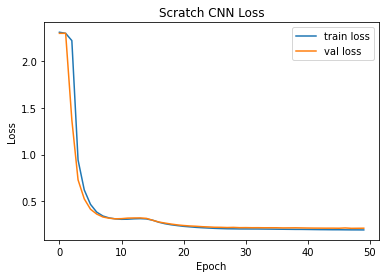

In [16]:
# ハイパーパラメータの設定 w(F,C,Lf) b(F)
W1 = np.array((4,1,6)); B1 = 4
W2 = np.array((8,4,6)); B2 = 8
W3 = np.array((16,8,3)); B3 = 16
W4 = np.array((752,188)); B4 = 188
W5 = np.array((188,10)); B5 = 10

# 5層のネットワーク
layer_1 = Layer(Conv1d(pad='SAME', stride=4), ReLu(), HeInitializer(), AdaGrad(), 784, W1, B1)  # 1,784 to 4,196
layer_2 = Layer(Conv1d(pad='SAME', stride=4), ReLu(), HeInitializer(), AdaGrad(), 4*196, W2, B2)  # 4,196 to 8,49
layer_3 = Layer(Conv1d(pad='VALID', stride=1), ReLu(), HeInitializer(), AdaGrad(), 8*49, W3, B3)  # 8,49 to 16,47
layer_4 = Layer(None, Flatten())  # 16,47 to 752,
layer_5 = Layer(Linear(), Sigmoid(), XavierInitializer(), AdaGrad(), 752, W4, B4)  # 752, to 188,
output = Layer(Linear(), Softmax(), XavierInitializer(), AdaGrad(), 188, W5, B5)  # 188, to 10,

params = {'epoch': 50, 
          'lr': 0.01,
          'batch_size': 200,
          }

cnn = Scratch1dCNNClassifier(layers=[layer_1, layer_2, layer_3, layer_4, layer_5, output],
                             verbose=True, **params)

cnn.fit(X_train, y_train, X_val, y_val)

pred = cnn.predict(X_test)

print("\nTest Accuracy: {}".format(accuracy_score(y_test, pred)))

plot_loss(cnn)

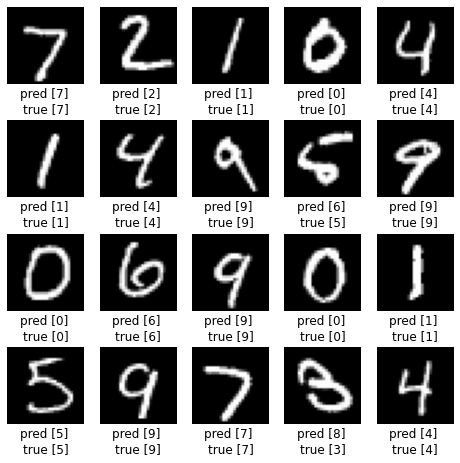

In [17]:
# 推定結果を確認
plt.figure(figsize=(8,8))
for i in range(20):
    pred = cnn.predict(X_test[i][None,...])
    true = y_test[i]
    plt.subplot(4, 5, i+1)
    plt.imshow(X_test[i].reshape(28,28), 'gray')
    plt.title('pred {} \ntrue [{}]'.format(pred, true), y=-0.45)
    plt.axis('off')